In [142]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

## Load data

In [143]:
load_data = pd.read_csv("./Data/Load_hourly_2050.csv")
load_data['date'] = load_data.apply(lambda x:pd.to_datetime(x['*Hour']-1, origin='2050-01-01',unit='h'),axis=1)
load_data

*Hour         Load                date
0         1  26927.58882 2050-01-01 00:00:00
1         2  26008.34278 2050-01-01 01:00:00
2         3  25292.68962 2050-01-01 02:00:00
3         4  24895.77208 2050-01-01 03:00:00
4         5  24933.29478 2050-01-01 04:00:00
...     ...          ...                 ...
8755   8756  31840.06796 2050-12-31 19:00:00
8756   8757  30699.46724 2050-12-31 20:00:00
8757   8758  29651.53631 2050-12-31 21:00:00
8758   8759  28576.43091 2050-12-31 22:00:00
8759   8760  27549.86278 2050-12-31 23:00:00

[8760 rows x 3 columns]

### define seasons

In [144]:
seasons = ['Winter', 'Spring', 'Summer', 'Fall']
def define_season(date):
    
    if ((date >= pd.Timestamp('2050-03-01')) and (date < pd.Timestamp('2050-06-01'))):
        return 'Spring'
    elif ((date >= pd.Timestamp('2050-06-01')) and (date < pd.Timestamp('2050-09-01'))):
        return 'Summer'
    elif ((date >= pd.Timestamp('2050-09-01')) and (date < pd.Timestamp('2050-12-01'))):
        return 'Fall'
    elif ((date < pd.Timestamp('2050-03-01')) or (date >=pd.Timestamp('2050-12-01'))): 
        return 'Winter'

load_data['Season'] = load_data['date'].apply(define_season)
load_data[load_data.Season == 'Spring']

*Hour         Load                date  Season
1416   1417  25404.15077 2050-03-01 00:00:00  Spring
1417   1418  24560.06866 2050-03-01 01:00:00  Spring
1418   1419  24135.54237 2050-03-01 02:00:00  Spring
1419   1420  23865.03363 2050-03-01 03:00:00  Spring
1420   1421  24152.63950 2050-03-01 04:00:00  Spring
...     ...          ...                 ...     ...
3619   3620  33572.39351 2050-05-31 19:00:00  Spring
3620   3621  34039.41975 2050-05-31 20:00:00  Spring
3621   3622  33187.42436 2050-05-31 21:00:00  Spring
3622   3623  31106.16149 2050-05-31 22:00:00  Spring
3623   3624  28900.29792 2050-05-31 23:00:00  Spring

[2208 rows x 4 columns]

## Nuclear, Hydro and other renewables

In [145]:
nuclear_gen = pd.read_csv('./Data/Nucl_hourly_2019.csv')
hydro_gen = pd.read_csv('./Data/lahy_hourly_2019.csv')
otre_gen = pd.read_csv('./Data/otre_hourly_2019.csv')
load_data = load_data.merge(right=otre_gen, on='*Hour')
load_data = load_data.merge(right=hydro_gen, on='*Hour')
load_data = load_data.merge(right=nuclear_gen, on='*Hour')

load_data['month'] = load_data['date'].dt.month
load_data['plottime'] = load_data.apply(lambda x:x['date'] if x['month'] !=12 else x['date']-pd.Timedelta(days=365),axis=1)
load_data = load_data.sort_values(by='plottime').reset_index(drop=True)
load_data

*Hour         Load                date  Season  OtherRenewables  \
0      8017  26271.43742 2050-12-01 00:00:00  Winter      1496.501788   
1      8018  25439.31354 2050-12-01 01:00:00  Winter      1502.798287   
2      8019  24872.22075 2050-12-01 02:00:00  Winter      1502.147954   
3      8020  24509.65717 2050-12-01 03:00:00  Winter      1505.046396   
4      8021  24387.42823 2050-12-01 04:00:00  Winter      1504.605409   
...     ...          ...                 ...     ...              ...   
8755   8012  32764.55344 2050-11-30 19:00:00    Fall      1606.670979   
8756   8013  32034.99661 2050-11-30 20:00:00    Fall      1595.594622   
8757   8014  31014.37051 2050-11-30 21:00:00    Fall      1576.381292   
8758   8015  29333.94398 2050-11-30 22:00:00    Fall      1541.431162   
8759   8016  27491.00889 2050-11-30 23:00:00    Fall      1534.406456   

       LargeHydro      Nuclear  month            plottime  
0     1486.397559  1133.150829     12 2049-12-01 00:00:00  
1     1266.426462  1133.624165     12 2049-12-01 01:00:00  
2     1045.435418  1133.693944     12 2049-12-01 02:00:00  
3      857.073098  1133.380390     12 2049-12-01 03:00:00  
4      923.568473  1133.602907     12 2049-12-01 04:00:00  
...           ...          ...    ...                 ...  
8755  2787.083745  1131.686667     11 2050-11-30 19:00:00  
8756  2391.385409  1132.218334     11 2050-11-30 20:00:00  
8757  2231.285197  1132.602505     11 2050-11-30 21:00:00  
8758  2035.587475  1132.806670     11 2050-11-30 22:00:00  
8759  1613.699324  1132.672511     11 2050-11-30 23:00:00  

[8760 rows x 9 columns]

## Define worst and random case scenario for each outage duration

In [146]:
scenario_dir = './resilience_scenarios/'
os.makedirs(scenario_dir, exist_ok=True)
from random import randint
durations = [6,12,24,72]

save_data = {}
zoomed_data = {}

for duration in durations:
    lp = load_data.copy()
    lr = load_data.copy()
    duration_dir_peak = os.path.join(scenario_dir,f'seasonpeak_outage_{duration}h/')
    duration_dir_random = os.path.join(scenario_dir,f'seasonrandom_outage_{duration}h/')
    os.makedirs(duration_dir_peak, exist_ok=True)
    os.makedirs(duration_dir_random, exist_ok=True)
    seasonpeak_outages_ids = {}
    seasonrandom_outages_ids = {}
    for season in seasons: 
        time_delta = pd.Timedelta(duration/2, unit='h')
        oneh = pd.Timedelta(1, unit='h')

        # Peak outage
        peak_hour_id = load_data[load_data.Season == season]['Load'].idxmax()
        seasonpeak_outages_ids[season] = peak_hour_id
        peak_hour = load_data.loc[peak_hour_id,'date']
        print(f"Peak hour for season {season} is {peak_hour}")
        lp.loc[ (lp.date>=peak_hour-time_delta+oneh) & (lp.date<=peak_hour+time_delta), 'OtherRenewables'] = 0
        lp.loc[ (lp.date>=peak_hour-time_delta+oneh) & (lp.date<=peak_hour+time_delta), 'LargeHydro'] = 0
        lp.loc[ (lp.date>=peak_hour-time_delta+oneh) & (lp.date<=peak_hour+time_delta), 'Nuclear'] = 0
        

        # Random outage
        random_id = randint(load_data[load_data.Season == season].index.min(), load_data[load_data.Season == season].index.max())
        seasonrandom_outages_ids[season] = random_id
        random_hour = load_data.loc[random_id,'date']
        #print(f"Random hour for outage during {season} season is {random_hour}")
        lr.loc[ (lr.date>=random_hour-time_delta+oneh) & (lr.date<=random_hour+time_delta), 'OtherRenewables'] = 0
        lr.loc[ (lr.date>=random_hour-time_delta+oneh) & (lr.date<=random_hour+time_delta), 'LargeHydro'] = 0
        lr.loc[ (lr.date>=random_hour-time_delta+oneh) & (lr.date<=random_hour+time_delta), 'Nuclear'] = 0
    lp.to_csv(os.path.join(duration_dir_peak,f'load_gen_{duration}h.csv'))
    lr.to_csv(os.path.join(duration_dir_random,f'load_gen_{duration}h.csv'))
    save_data[f'seasonpeak_outage_{duration}h'] = lp
    save_data[f'seasonrandom_outage_{duration}h'] = lr

    zoomed_data[f'seasonpeak_outage_{duration}h'] = {'data':lp, 'ids':seasonpeak_outages_ids, 'duration':duration}
    zoomed_data[f'seasonrandom_outage_{duration}h'] = {'data':lr, 'ids':seasonrandom_outages_ids, 'duration':duration}
    


    

Peak hour for season Winter is 2050-12-16 18:00:00
Peak hour for season Spring is 2050-04-24 19:00:00
Peak hour for season Summer is 2050-08-15 17:00:00
Peak hour for season Fall is 2050-09-03 17:00:00
Peak hour for season Winter is 2050-12-16 18:00:00
Peak hour for season Spring is 2050-04-24 19:00:00
Peak hour for season Summer is 2050-08-15 17:00:00
Peak hour for season Fall is 2050-09-03 17:00:00
Peak hour for season Winter is 2050-12-16 18:00:00
Peak hour for season Spring is 2050-04-24 19:00:00
Peak hour for season Summer is 2050-08-15 17:00:00
Peak hour for season Fall is 2050-09-03 17:00:00
Peak hour for season Winter is 2050-12-16 18:00:00
Peak hour for season Spring is 2050-04-24 19:00:00
Peak hour for season Summer is 2050-08-15 17:00:00
Peak hour for season Fall is 2050-09-03 17:00:00


## Graphs

Iterate through all scenarios and durations and create and save plots in respective folders

In [147]:
import matplotlib.dates as mdates

In [148]:
def plot_scenario2(scenario_name, df, ids, duration):
    save_dir = os.path.join(scenario_dir,scenario_name+'/')
    
    # Convert to GW
    df['OtherRenewables'] /=1e3
    df['LargeHydro'] /=1e3
    df['Nuclear'] /=1e3
    df['Load'] /=1e3

    fig = plt.figure(layout='constrained', figsize=(20,10))
    subs = fig.subfigures(2,2,wspace=0.05)

    # Indicators for the subfigure for each season
    seasons_locations = {'Winter':{'row':0, 'col':0},
                         'Spring':{'row':0, 'col':1},
                         'Summer':{'row':1, 'col':0},
                         'Fall':{'row':1, 'col':1}}
    for season in seasons:
        seasondf = df[df.Season == season]
        df1 = seasondf.set_index('plottime').sort_index()
        
        # Load and generation on the left
        row = seasons_locations[season]['row']
        col = seasons_locations[season]['col']
        subfigs = subs[row,col].subfigures(1,2,width_ratios =[1,0.5])
        ax = subfigs[0].subplots(2,1,sharex=True,gridspec_kw={
                           'height_ratios': [1, 2]} )
        # Plot the load first
        ax[0].plot(df1.index, df1['Load'], label='Load', color='red', alpha=0.6)
        ax[0].set_title(season)
        ax[0].set_ylim(20,55)
        ax[0].xaxis.set(major_locator=mdates.MonthLocator(), major_formatter=mdates.DateFormatter('%m-%d'))
        ax[0].set_ylabel('Load [GW]')
        ax[0].yaxis.grid(True)
        # Plot the generation next
        ax[1].plot(df1.index, df1['OtherRenewables'], label='Other Renewables', color='green', alpha=0.7)
        ax[1].plot(df1.index, df1['LargeHydro'], label='LargeHydro', color='skyblue', alpha=0.7)
        ax[1].plot(df1.index, df1['Nuclear'], label='Nuclear', color='darkviolet', alpha=0.7)
        ax[1].set_ylim(-0.10,6.1)
        ax[1].xaxis.set(major_locator=mdates.MonthLocator(), major_formatter=mdates.DateFormatter('%m-%d'))
        ax[1].set_ylabel('Generation [GW]')
        ax[1].yaxis.grid(True)

        # Zoom of the outage in the generation on the right
        axe = subfigs[1].subplots()

        outage_id = ids[season]
        end_outage = outage_id+duration/2
        start_outage = outage_id-duration/2
        seasondf = seasondf[(seasondf.index>=start_outage-12)&(seasondf.index <= end_outage+12)]
        seasondf = seasondf.set_index('plottime').sort_index()
        axe.plot(seasondf.index, seasondf['OtherRenewables'], label='Other Renewables', color='green', alpha=0.7)
        axe.plot(seasondf.index, seasondf['LargeHydro'], label='LargeHydro', color='skyblue', alpha=0.7)
        axe.plot(seasondf.index, seasondf['Nuclear'], label='Nuclear', color='darkviolet', alpha=0.7)

        axe.xaxis.set_major_locator(mdates.DayLocator())
        axe.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d %H:%M'))
        axe.xaxis.set_minor_locator(mdates.HourLocator((0,6,12,18)))
        axe.xaxis.set_minor_formatter(mdates.DateFormatter('%H:%M'))
        axe.xaxis.grid(True, which='both')
        axe.yaxis.grid(True)
        axe.tick_params(axis="x", which="major", rotation=80)
        axe.tick_params(axis='x',which='minor', rotation=75)
        axe.set_ylabel('Generation [GW]')
        axe.set_title(f'Zoom on {season} outage')
        
        
    handles, labels = ax[0].get_legend_handles_labels()
    h, l = ax[1].get_legend_handles_labels()
    fig.legend(handles+h, labels+l, ncols=4, bbox_to_anchor=(0.3,1.005))
    title0 = scenario_name.split('_')[0][6:]
    title1 = scenario_name.split('_')[-1][:-1]
    fig.suptitle(f'Resilience scenario:\nseason {title0}, {title1}h duration ')
    fig.savefig(os.path.join(save_dir, scenario_name+'.png'))

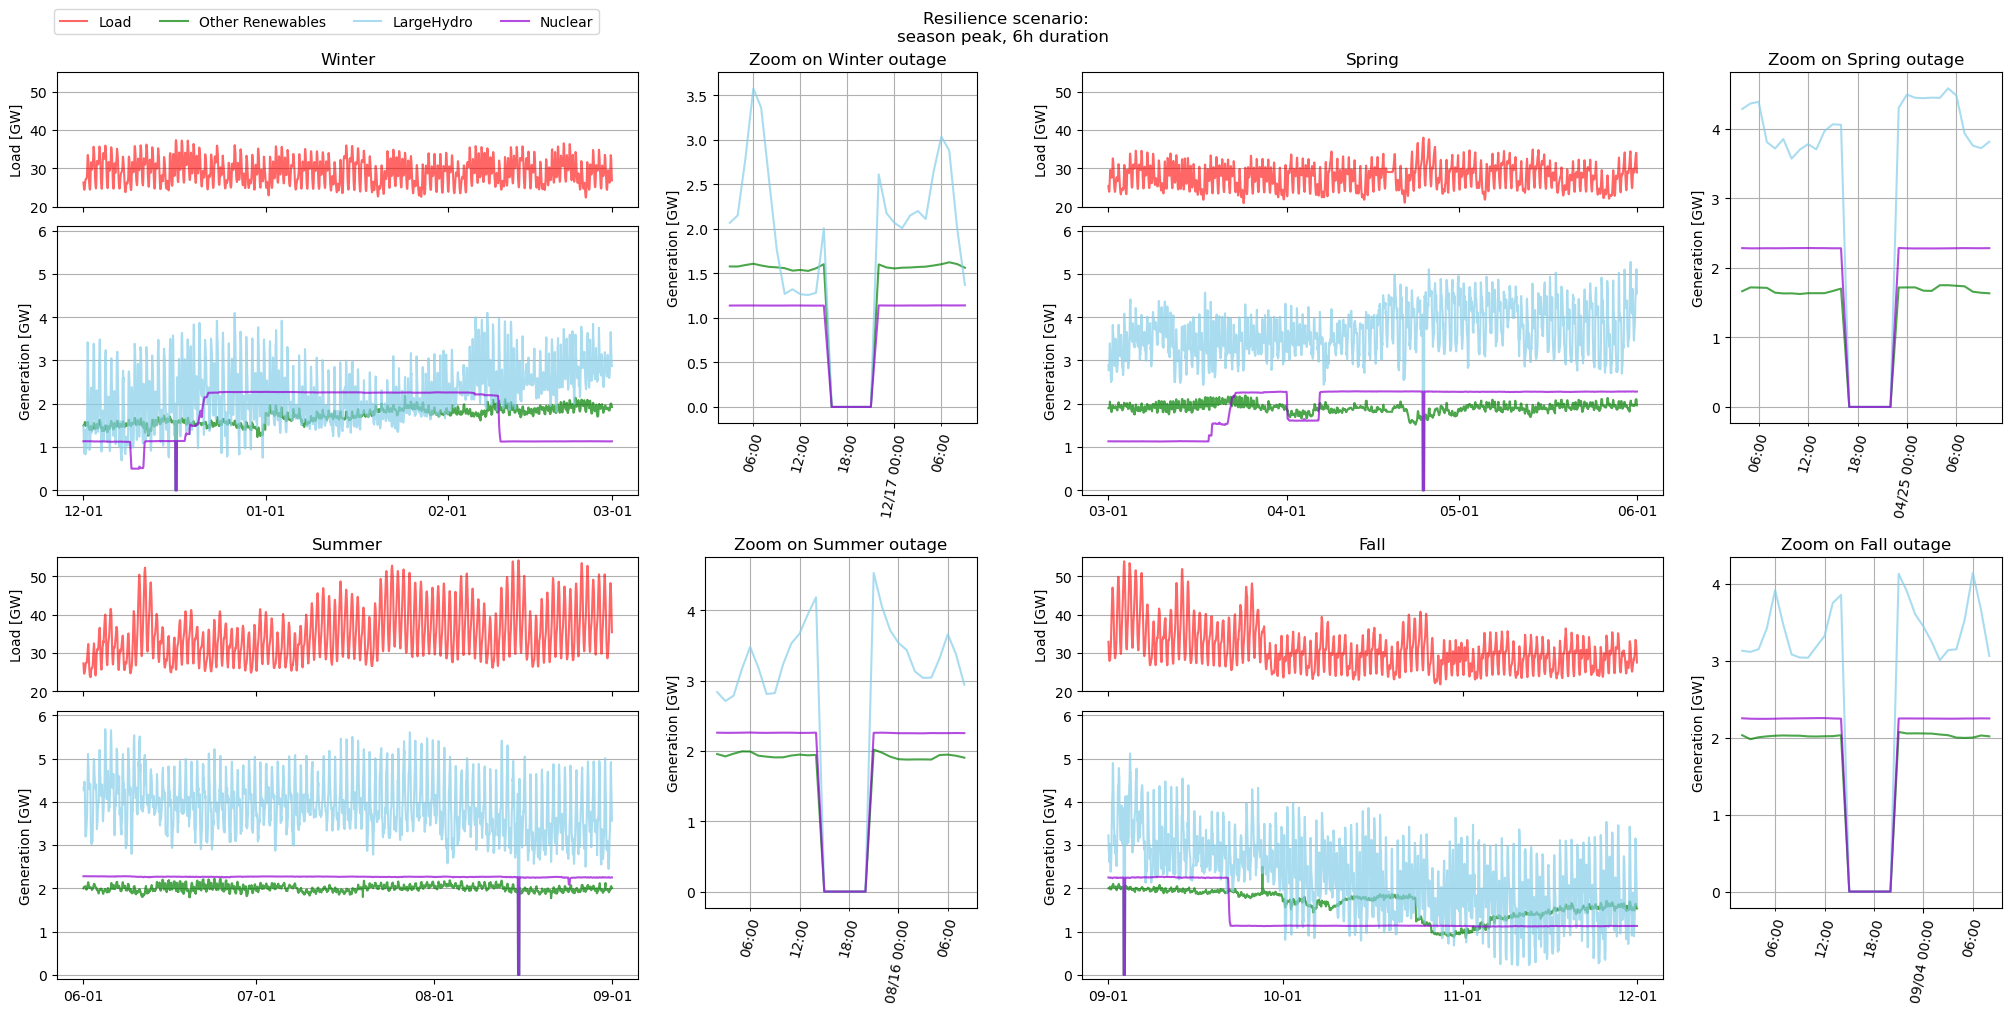

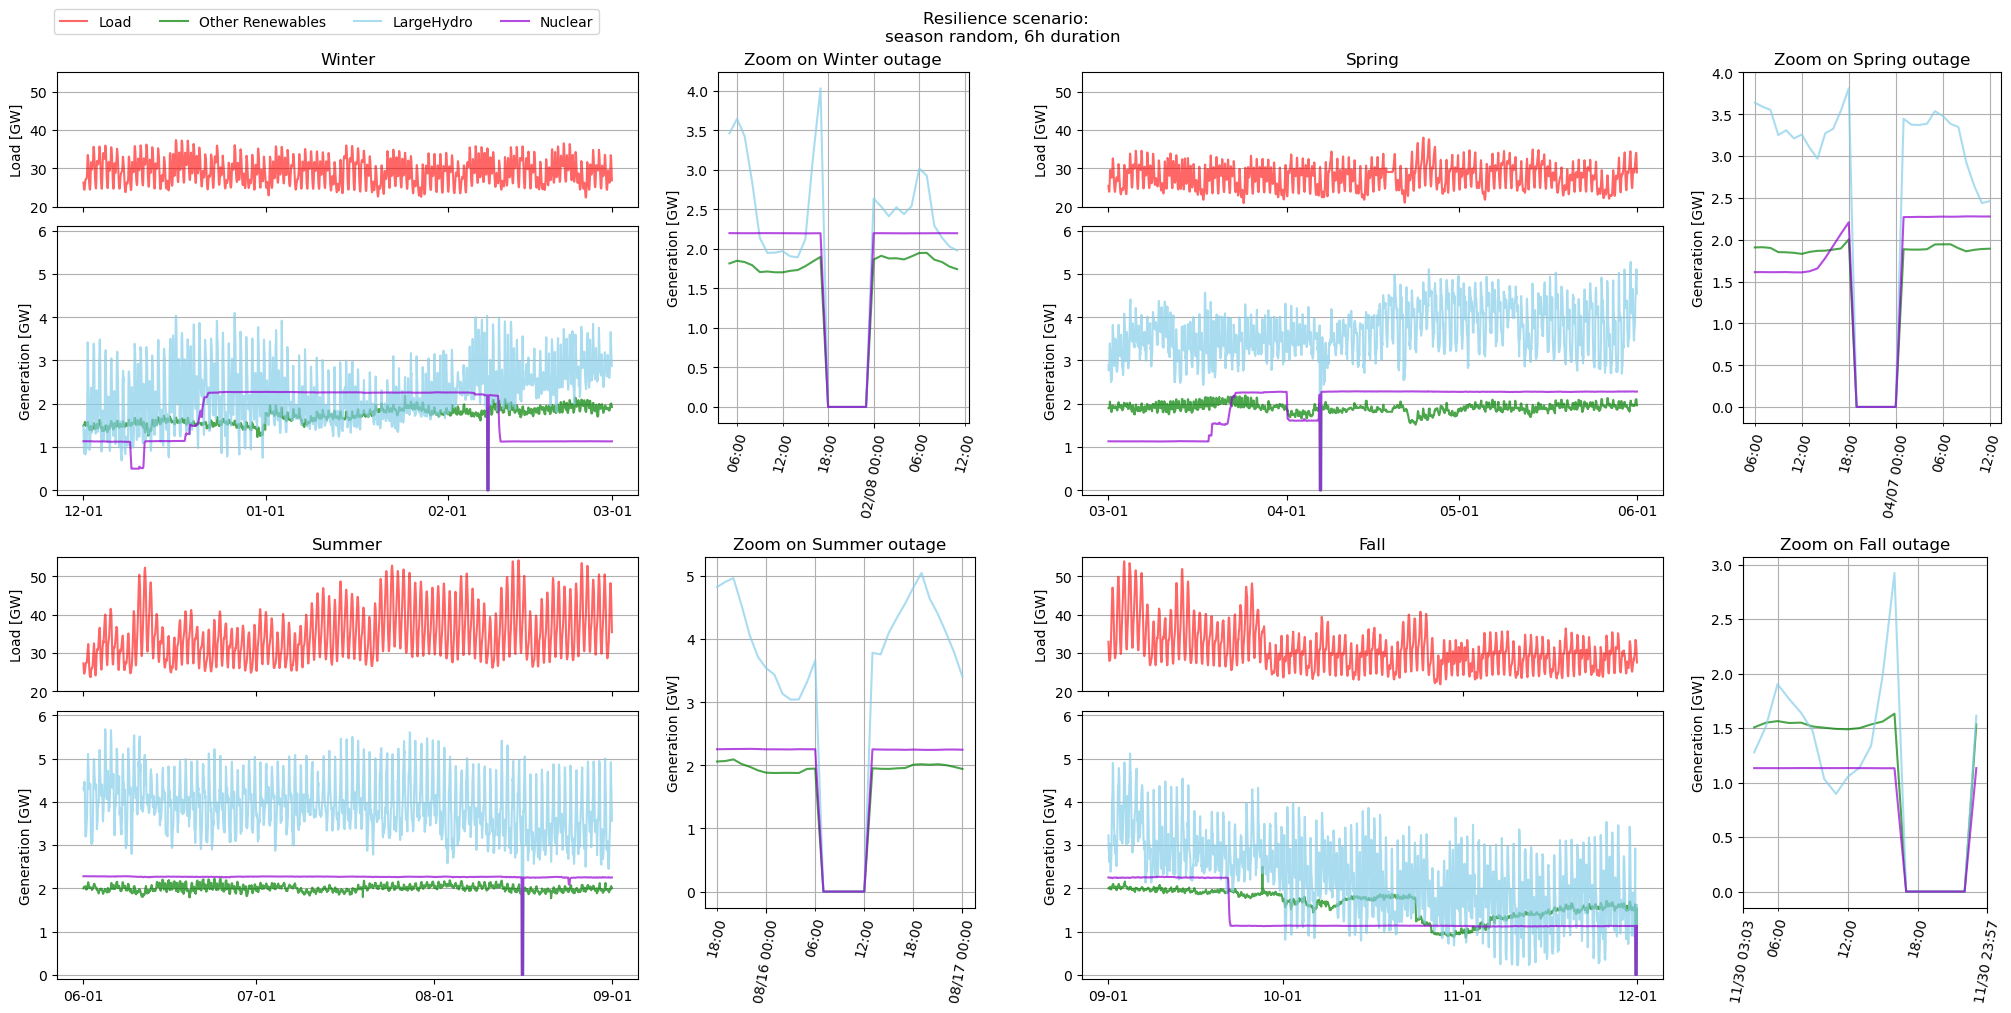

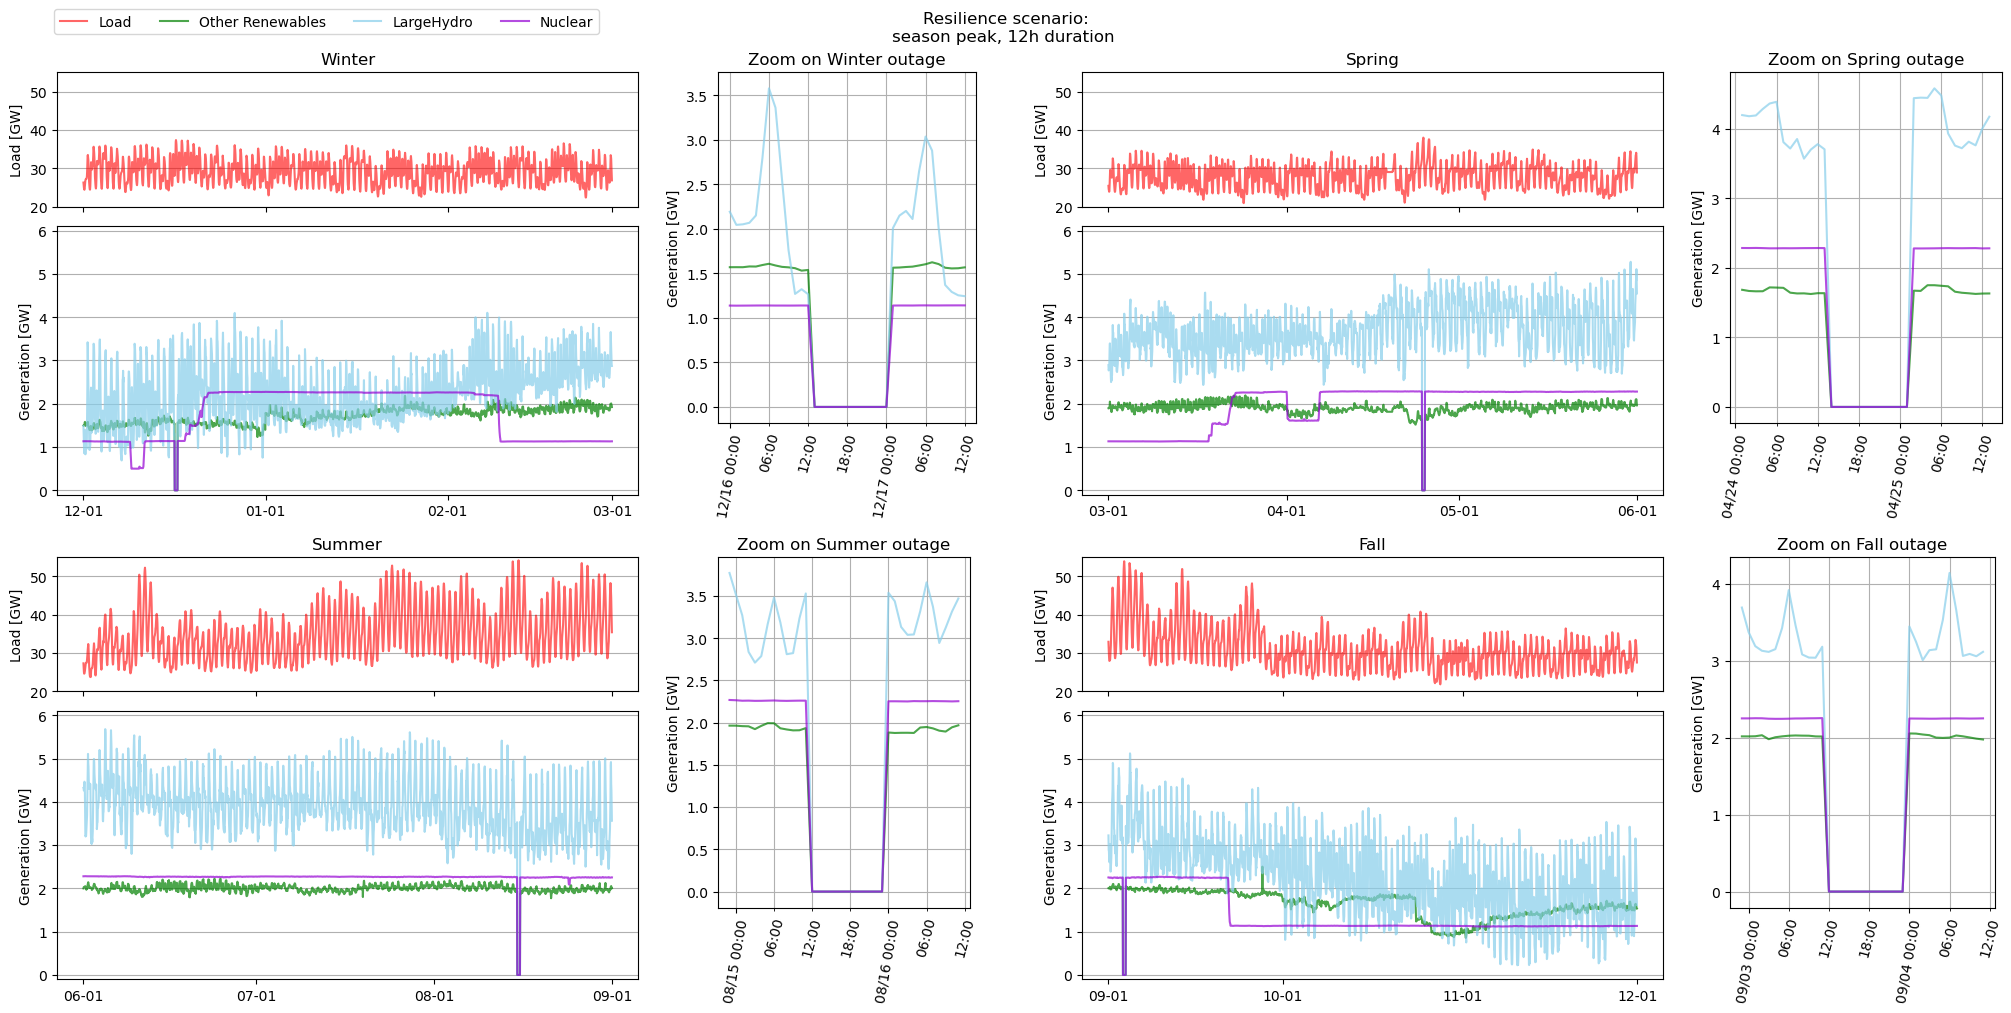

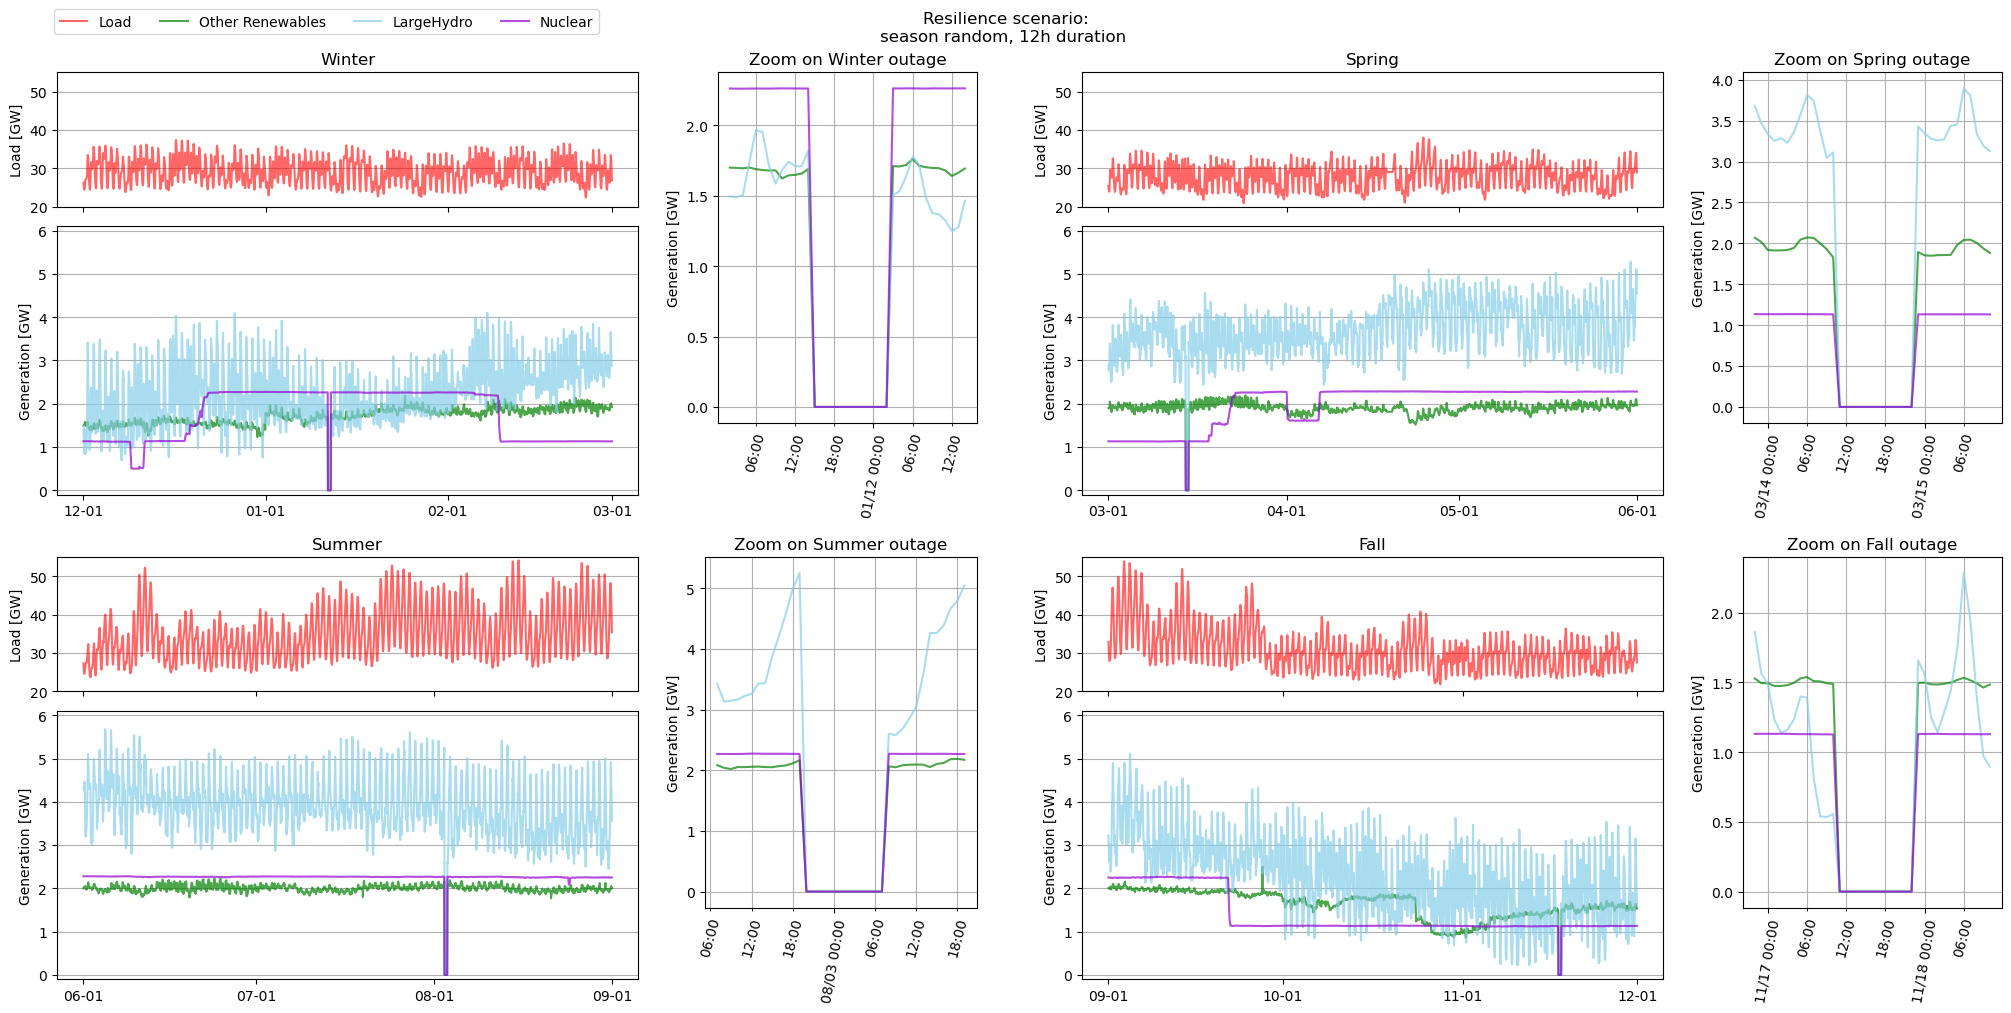

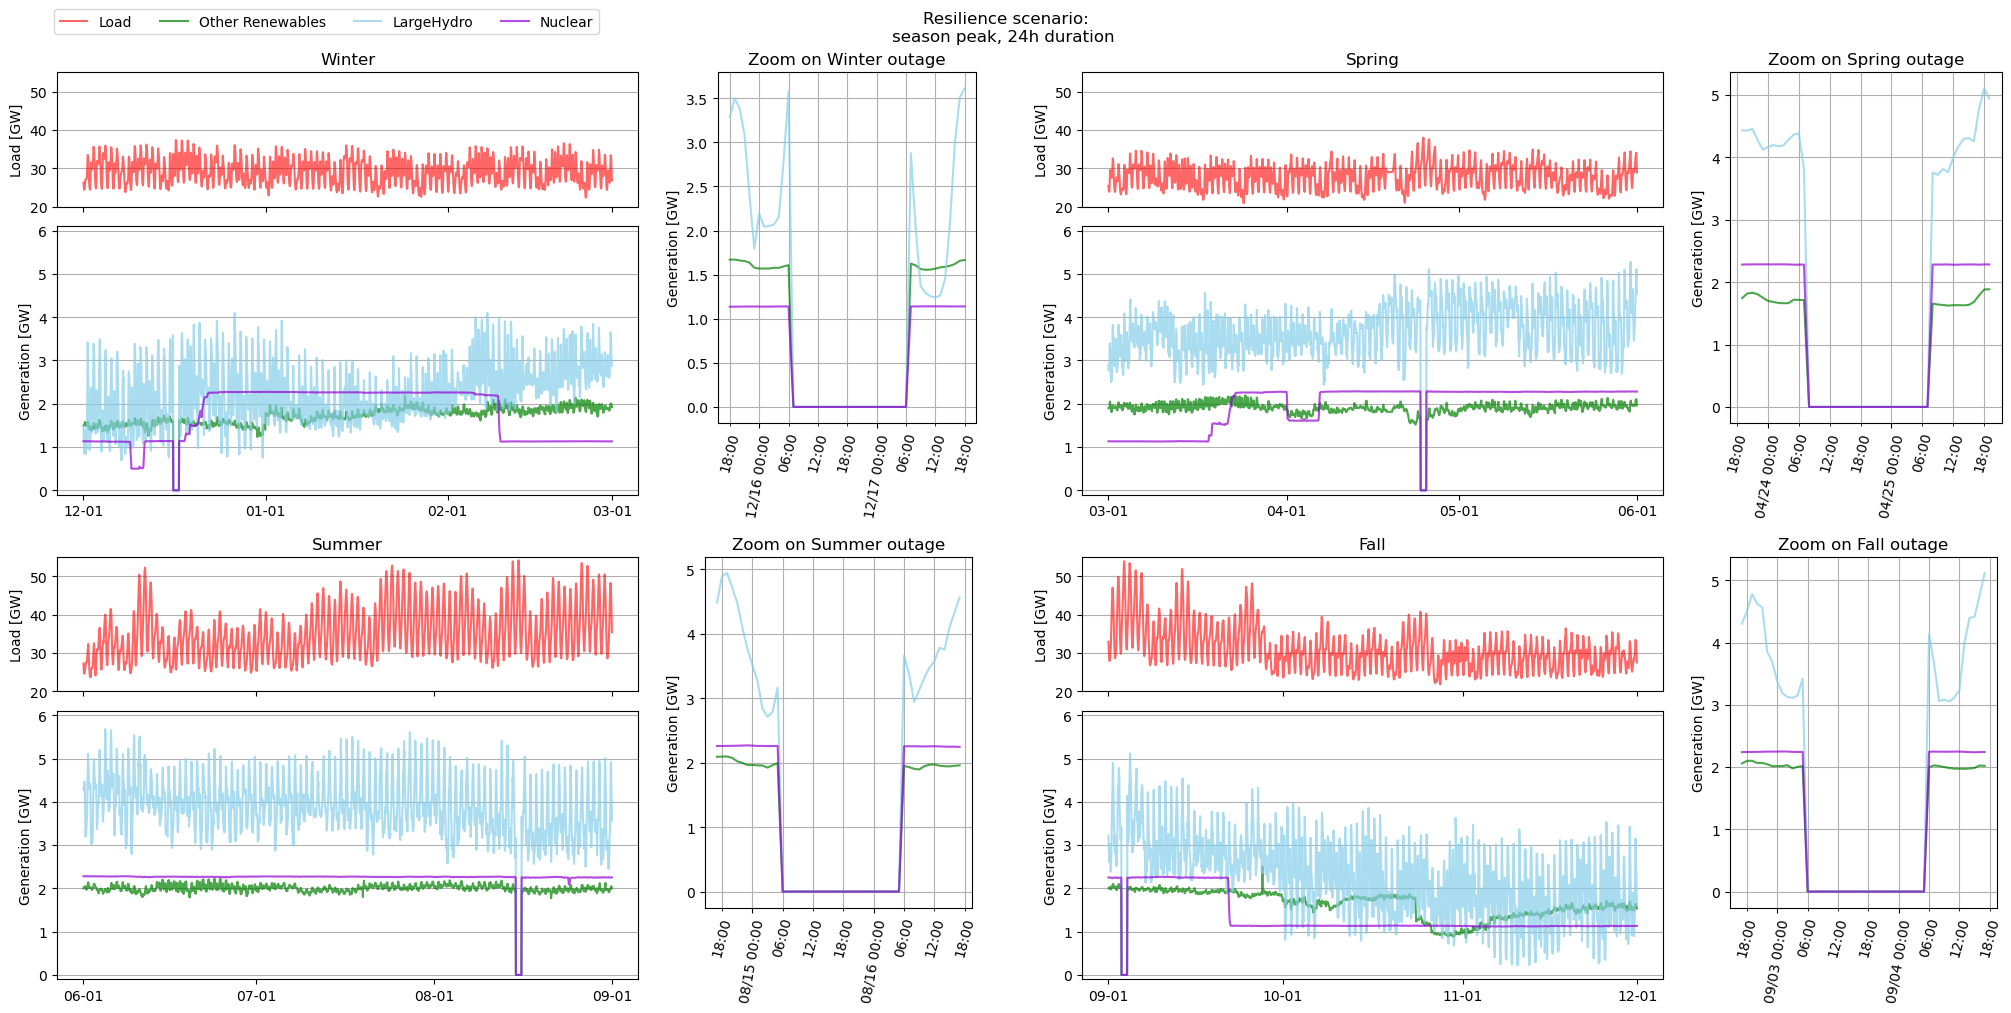

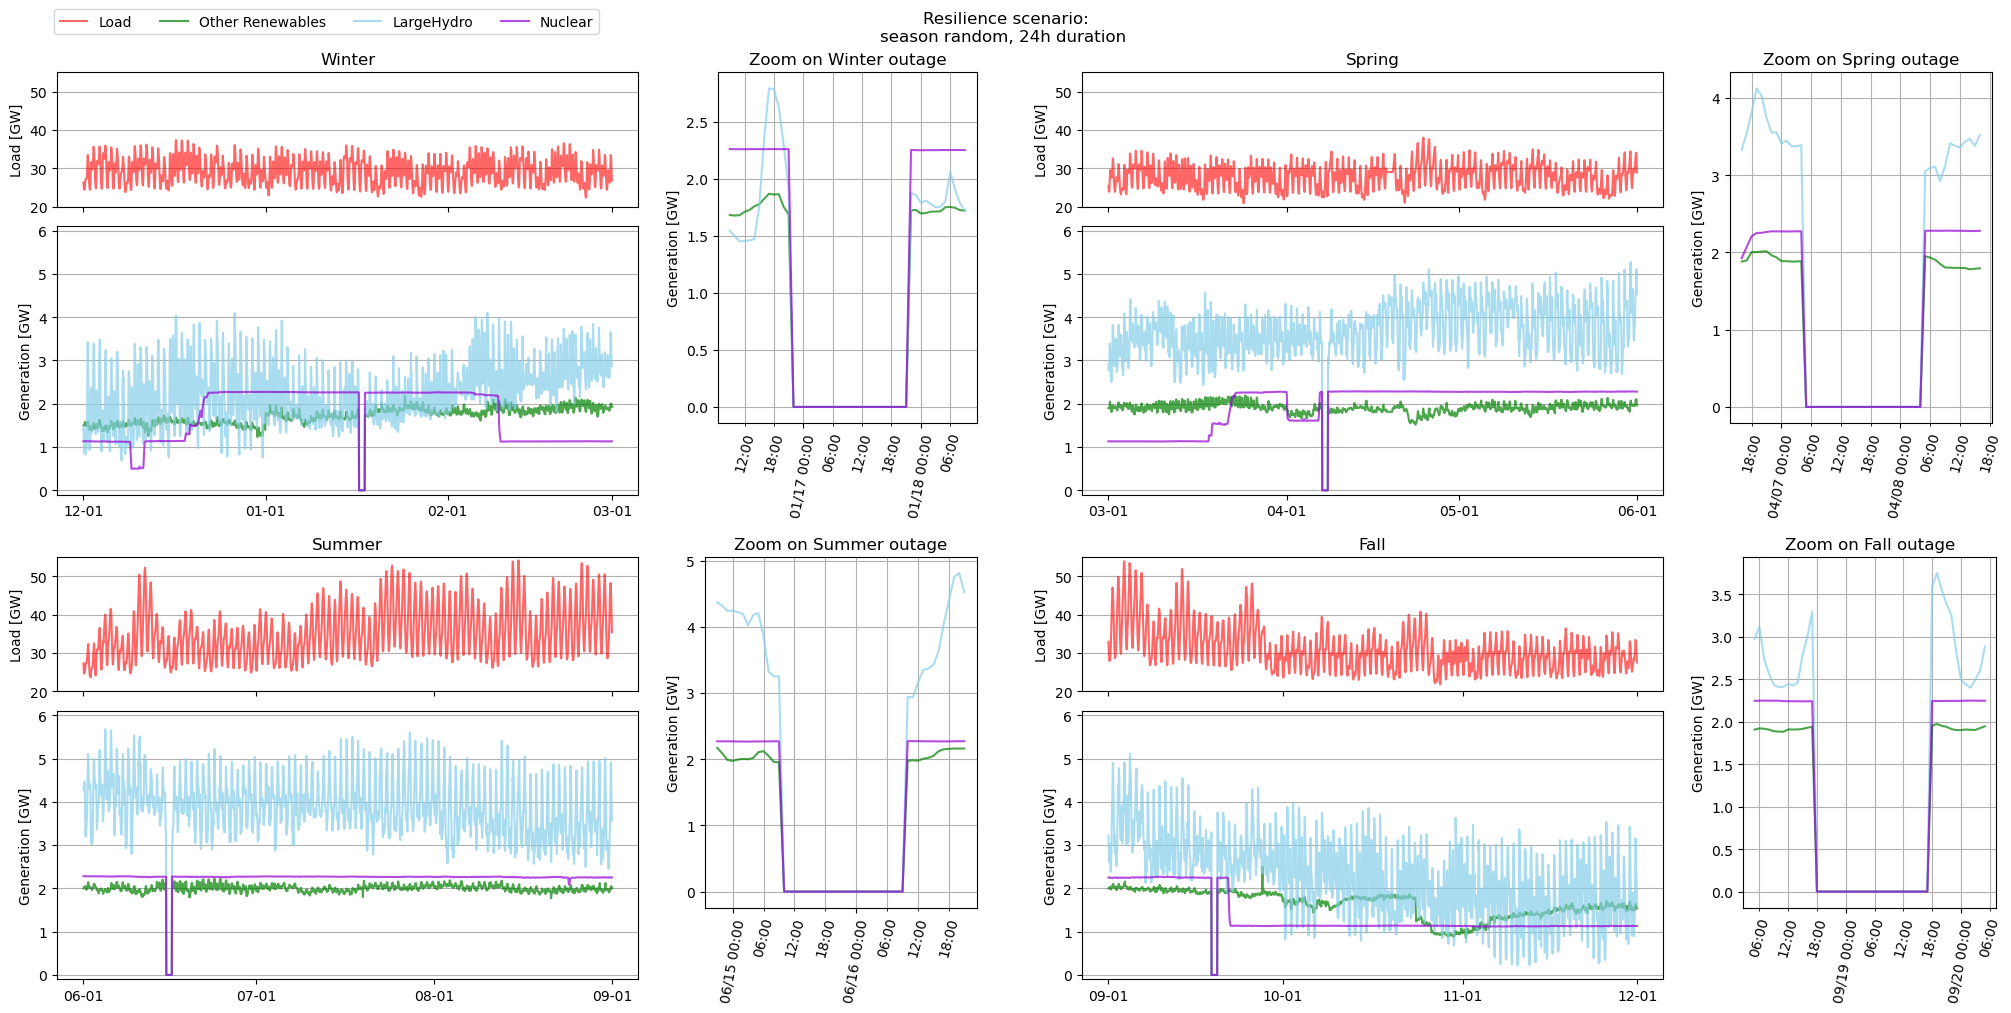

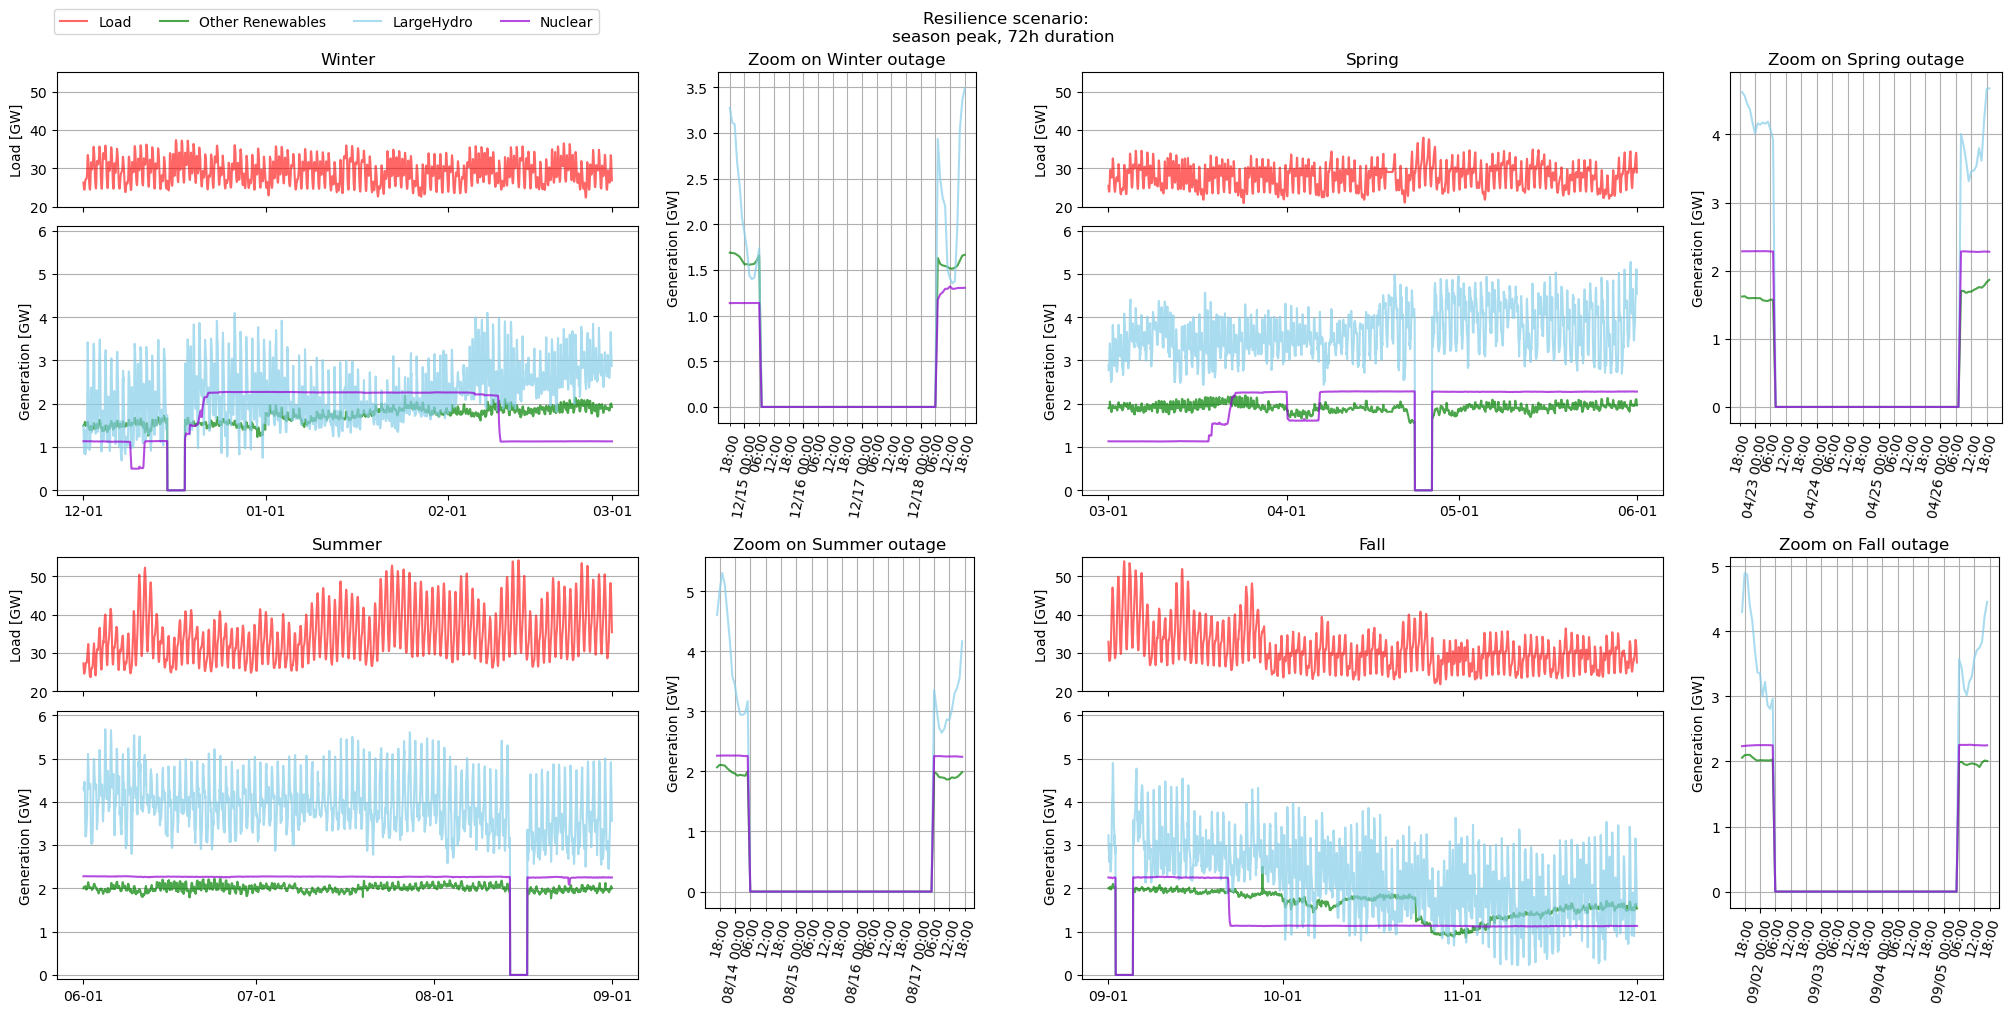

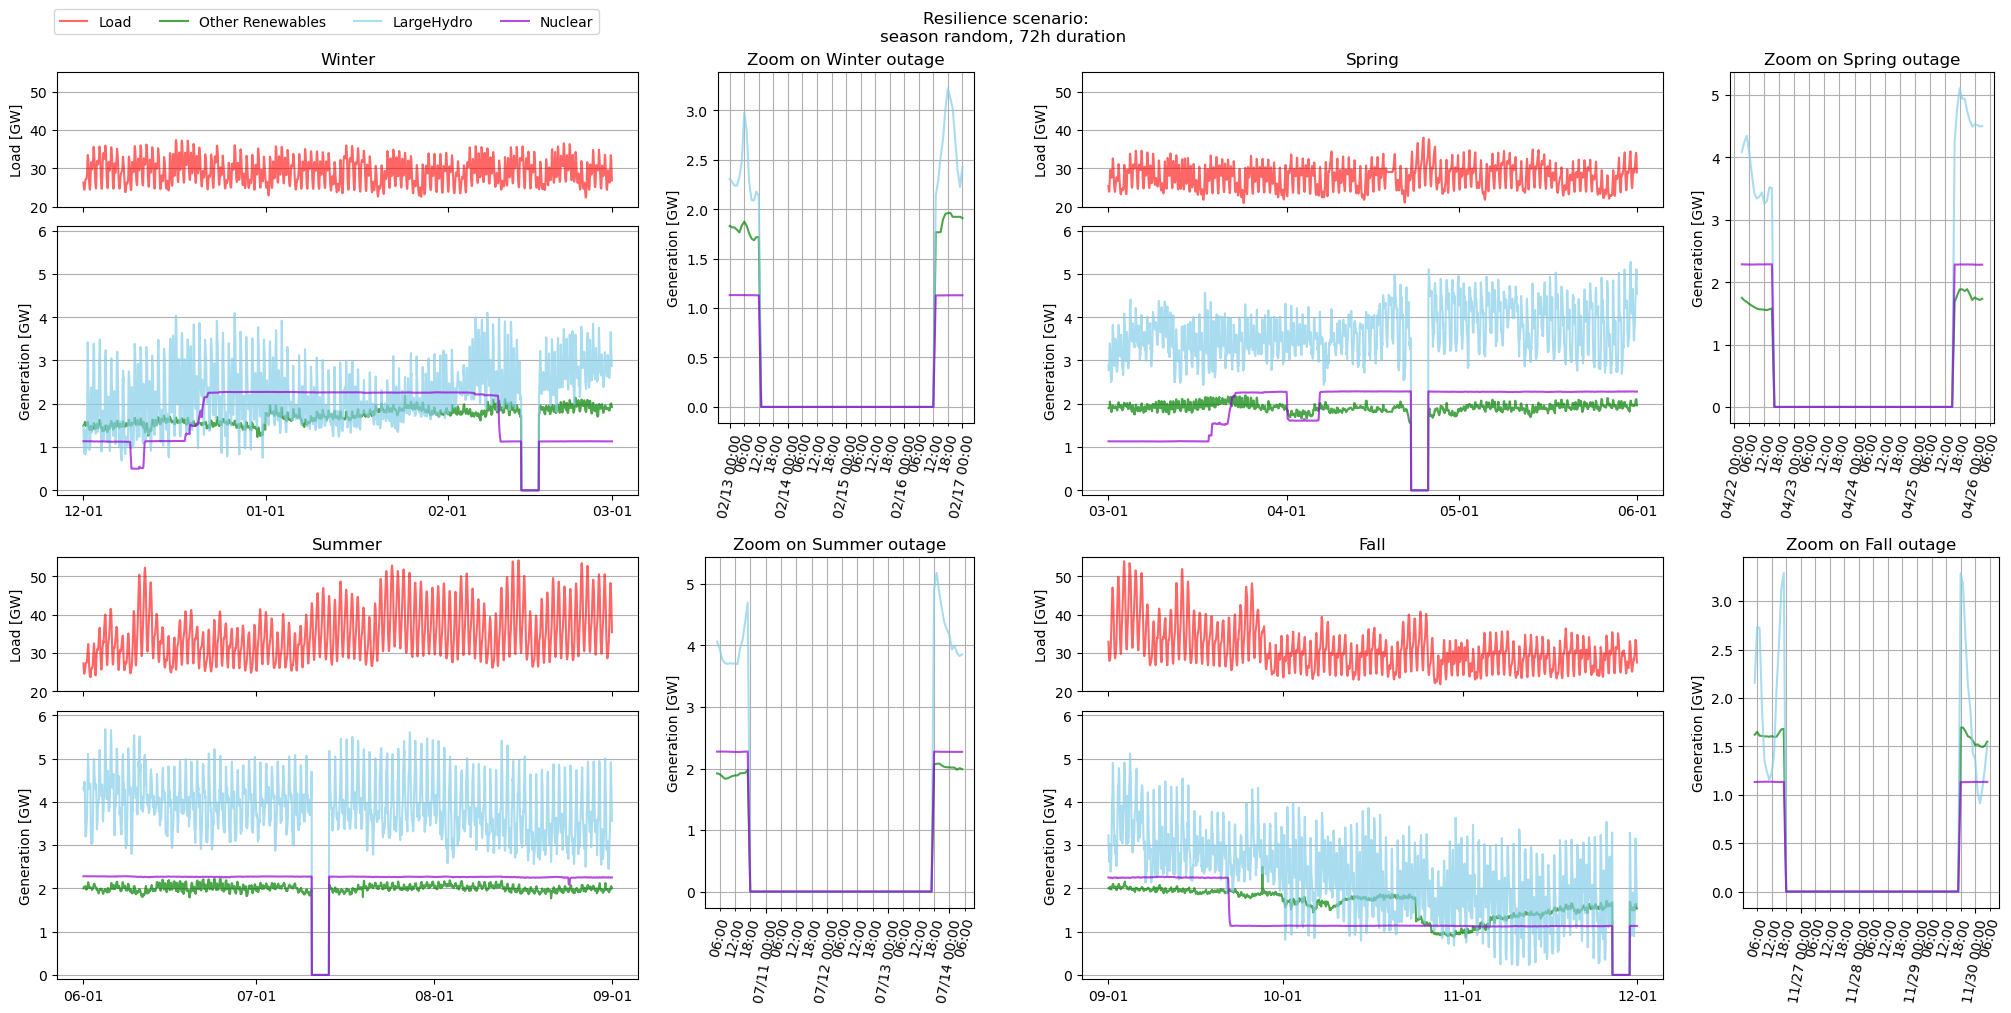

In [149]:
for scenario, aggdata in zoomed_data.items():
    data = aggdata['data']
    duration = aggdata['duration']
    ids = aggdata['ids']
    plot_scenario2(scenario_name=scenario, df=data, ids=ids, duration=duration)